In [1]:
!nvidia-smi

Mon Oct 27 14:30:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.05              Driver Version: 560.35.05      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           Off |   00000000:1A:00.0 Off |                    0 |
| N/A   36C    P0             58W /  300W |     550MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:

import sys
sys.path.append("../../")
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
os.environ["JAX_PLATFORMS"] = "cuda"  # or: os.environ["JAX_PLATFORM_NAME"]="cuda"
#using GPU, comment out if on CPU?
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import jax
jax.config.update("jax_disable_jit", False)

jax.config.update("jax_debug_nans", True)
print(jax.lib.xla_bridge.get_backend().platform_version)  # sanity: shows CUDA/cuDNN


/tmp/ipykernel_1942809/1344735116.py:15: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  print(jax.lib.xla_bridge.get_backend().platform_version)  # sanity: shows CUDA/cuDNN


PJRT C API
cuda 12030


In [3]:
import diffhydro as dh


eq = dh.equationmanager.EquationManager()
eq.mesh_shape=[100,100,100]

In [4]:
U = dh.turbulence.init_turbulent_velocity(eq, 100, 1.0, 1.0,kmax=10)

2025-10-27 14:30:27.194896: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.6 which is older than the PTX compiler version 12.9.86. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


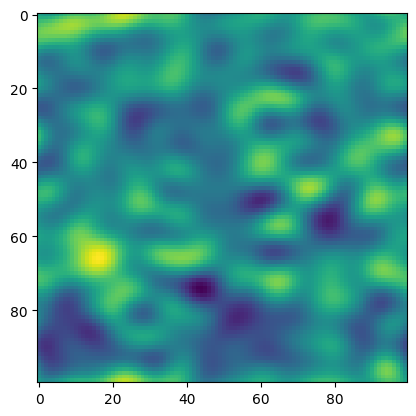

In [5]:
%pylab inline
imshow(U[3][30])

In [6]:
ss = dh.signal_speed_Rusanov

solver = dh.HLLC(equation_manager=eq,signal_speed=ss)

cf = dh.ConvectiveFlux(eq,solver,dh.MUSCL3(limiter="VANLEER"),positivity=False)
#ct = dh.mhd.ConstrainedTransportFlux(eq, solver, dh.MUSCL3(limiter="MINMOD"), positivity=False)

hydro = dh.hydro(n_super_step=1000, fluxes=[cf],forces=[],use_mol=True, use_ctu=False, integrator="SSPRK3") 

using CTU? False


In [7]:
params = {}
output = hydro.evolve(U,params)

dt [Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>]
using CTU? False


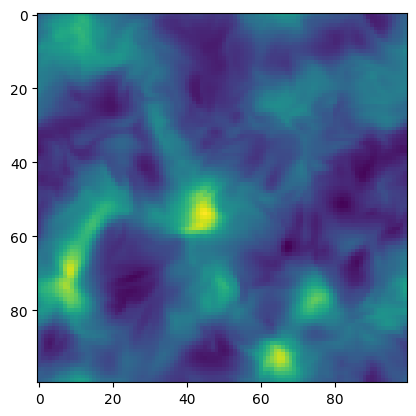

In [8]:
imshow(output[0][0][30])

In [9]:
TF = dh.turbulence.TurbulentForce(eq)

In [10]:
hydro = dh.hydro(n_super_step=1000, fluxes=[cf],forces=[TF],use_mol=True, use_ctu=False, integrator="SSPRK3") 

using CTU? False


In [11]:
params = {}
output = hydro.evolve(U,params)

dt [Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>, 10000000000.0]
using CTU? False


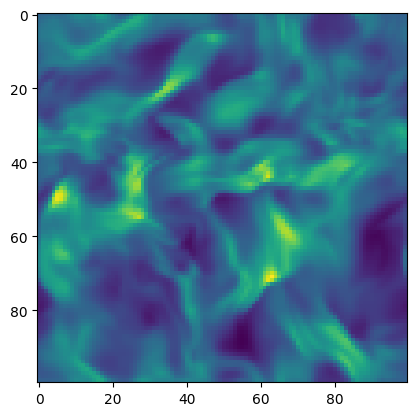

In [12]:
imshow(output[0][0][30]) #cool!